In [1]:
""" To DO:
        Scrape DRONE Exclusive data from NuForc and Append to end of dataset 
        preprocess Data and get rid of inorrect variables or data points 
        part 2 
        part 3
"""

' To DO:\n        Scrape DRONE Exclusive data from NuForc and Append to end of dataset \n        preprocess Data and get rid of inorrect variables or data points \n        part 2 \n        part 3\n'

In [2]:
!pip uninstall torch -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Found existing installation: torch 2.6.0+cpu
Uninstalling torch-2.6.0+cpu:
  Successfully uninstalled torch-2.6.0+cpu
Looking in indexes: https://download.pytorch.org/whl/cpu
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cpu/torch-2.6.0%2Bcpu-cp311-cp311-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cpu/torch-2.6.0%2Bcpu-cp311-cp311-win_amd64.whl.metadata (28 kB)
Using cached https://download.pytorch.org/whl/cpu/torch-2.6.0%2Bcpu-cp311-cp311-win_amd64.whl (206.5 MB)


!pip install torch

In [3]:
!pip install wordcloud
!pip install transformers
!pip install selenium

Load Necessary Libraries

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from transformers import pipeline
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = stopwords.words('english')

#load spacy english model
nlp = spacy.load("en_core_web_sm")

#get stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#add stopwords
stop_words.update(['I','like','look','see','one'])


c:\Users\mikek\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mikek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mikek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mikek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Scrape Data

Setup Chrome Driver

In [5]:
# Step 1: Set up ChromeDriver path
chrome_driver_path = r"C:/Users/mikek/chromedriver-win64/chromedriver.exe"

# Step 2: Set up Selenium WebDriver
options = Options()
options.add_argument("--headless")  # Run in headless mode
service = Service(chrome_driver_path)
driver = webdriver.Chrome(service=service, options=options)


In [6]:

#  Open NUFORC Reports by Month Page
url = "https://nuforc.org/ndx/?id=event"
driver.get(url)
time.sleep(3)  # Wait for the page to load

# Extract all year-month event links
all_links = driver.find_elements(By.TAG_NAME, 'a')
valid_links = []

for link in all_links:
    link_text = link.text.strip()

    # Extract only links that belong to 2023, 2024, or 2025
    if any(year in link_text for year in ["2023", "2024", "2025"]):
        valid_links.append((link.get_attribute('href'), link_text))  # Store URL + month-year text

    # Stop when we encounter a year before 2023
    elif any(year in link_text for year in ["2022", "2021", "2020"]):
        print("✅ Stopping extraction as we reached a year below 2023.")
        break

print(f"🔍 Found {len(valid_links)} monthly event links for 2023-2025.")

#create data storage
data = []

# Step 6: Scrape Data from Each Monthly Report Page
for month_url, month_year_text in valid_links:
    print(f"\n🌍 Scraping data from: {month_url}")
    print(f"📅 Currently Scraping: **{month_year_text}**")

    driver.get(month_url)
    time.sleep(3)  #wait for the page to load 

    #extract table data
    rows = driver.find_elements(By.TAG_NAME, "tr")

    for row in rows[1:]:  # skip header
        cols = row.find_elements(By.TAG_NAME, "td")
        cols_text = [col.text.strip() for col in cols]

        # make sure all columns are aligned 
        corrected_row = {
            "Link": cols_text[0] if len(cols_text) > 0 else "",
            "Month-Year": month_year_text,
            "Occurred": cols_text[1] if len(cols_text) > 1 else "",
            "City": cols_text[2] if len(cols_text) > 2 else "",
            "State": cols_text[3] if len(cols_text) > 3 else "",
            "Country": cols_text[4] if len(cols_text) > 4 else "",
            "Shape": cols_text[5] if len(cols_text) > 5 else "",
            "Summary": cols_text[6] if len(cols_text) > 6 else "",
            "Reported": cols_text[7] if len(cols_text) > 7 else "",
            "Media": cols_text[8] if len(cols_text) > 8 else "",  # line up y values 
            "Explanation": cols_text[9] if len(cols_text) > 9 else ""  # explanation map
        }

        data.append(corrected_row)

    print(f"✅ Extracted {len(rows)-1} reports from this month.")

#  Step 7: Close WebDriver
driver.quit()

# Step 8: Convert Data to Pandas DataFrame
df = pd.DataFrame(data)

#Step 9: Save Data to CSV
csv_path = f"ufo_reports_2023_to_2025_{time.strftime('%Y%m%d_%H%M%S')}.csv"
df.to_csv(csv_path, index=False)

print(f"\n✅ Scraping completed! Data saved to **{csv_path}** 🎉")


✅ Stopping extraction as we reached a year below 2023.
🔍 Found 26 monthly event links for 2023-2025.

🌍 Scraping data from: https://nuforc.org/subndx/?id=e202502
📅 Currently Scraping: **2025/02**
✅ Extracted 101 reports from this month.

🌍 Scraping data from: https://nuforc.org/subndx/?id=e202501
📅 Currently Scraping: **2025/01**
✅ Extracted 101 reports from this month.

🌍 Scraping data from: https://nuforc.org/subndx/?id=e202412
📅 Currently Scraping: **2024/12**
✅ Extracted 101 reports from this month.

🌍 Scraping data from: https://nuforc.org/subndx/?id=e202411
📅 Currently Scraping: **2024/11**
✅ Extracted 101 reports from this month.

🌍 Scraping data from: https://nuforc.org/subndx/?id=e202410
📅 Currently Scraping: **2024/10**
✅ Extracted 101 reports from this month.

🌍 Scraping data from: https://nuforc.org/subndx/?id=e202409
📅 Currently Scraping: **2024/09**
✅ Extracted 101 reports from this month.

🌍 Scraping data from: https://nuforc.org/subndx/?id=e202408
📅 Currently Scraping: 

Scrape Recent Drone Data (If you've seen the news)

In [7]:
#Scrape Drone Reports with Correct Columns
drone_url = "https://nuforc.org/subndx/?id=d"
print(f"\n🌍 Scraping drone reports from: {drone_url}")
driver.get(drone_url)
time.sleep(3)

drone_data = []
while True:
    rows = driver.find_elements(By.TAG_NAME, "tr")

    for row in rows[1:]: 
        cols = row.find_elements(By.TAG_NAME, "td")
        
        cols_text = [col.text.strip() if col.text.strip() != "" else "" for col in cols]

        while len(cols_text) < 10:
            cols_text.append("")

       
        drone_data.append({
            "Link": cols_text[0],  # "Open"
            "Occurred": cols_text[1],
            "City": cols_text[2],
            "State": cols_text[3],
            "Country": cols_text[4],
            "Shape": cols_text[5],
            "Summary": cols_text[6],
            "Reported": cols_text[7], 
            "Media": cols_text[8],  
            "Explanation": cols_text[9]  
        })

    print(f"✅ Extracted {len(rows) - 1} drone reports from this page.")

    #check for pagination
    try:
        next_button = driver.find_element(By.ID, "table_1_next")
        if "disabled" in next_button.get_attribute("class"):
            print("✅ No more pages for drone reports.")
            break

        print("➡️ Clicking 'Next' to load more drone reports...")
        driver.execute_script("arguments[0].scrollIntoView();", next_button)
        time.sleep(1)
        next_button.click()
        time.sleep(3)

    except Exception:
        print("✅ No pagination detected, ending drone scraping.")
        break

#Convert Drone Data to Pandas DataFrame
df_drones = pd.DataFrame(drone_data, columns=[
    "Link", "Occurred", "City", "State", "Country", 
    "Shape", "Summary", "Reported", "Media", "Explanation"
])

#save Drone Data to CSV
df_drones.to_csv("drone_reports.csv", index=False)

print("\n🚁 Drone Reports → 'drone_reports.csv' saved successfully!")



🌍 Scraping drone reports from: https://nuforc.org/subndx/?id=d


MaxRetryError: HTTPConnectionPool(host='localhost', port=20157): Max retries exceeded with url: /session/a76b3d6837aeaa220d72cc36d3ace482/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002033A704590>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

Read the data in

In [ ]:
ufo_data = pd.read_csv("nuforc_data_2023_2025.csv")
print(ufo_data.head())  

   Link Month-Year         Occurred             City           State  \
0  Open    2025/01  1/30/2025 20:10          Holyoke              MA   
1  Open    2025/01  1/30/2025 19:42           Duluth              MN   
2  Open    2025/01  1/30/2025 18:35          Smrjene       Ljubljana   
3  Open    2025/01  1/30/2025 18:00           Maldon         England   
4  Open    2025/01   1/30/2025 7:48  Sfântu Gheorghe  Covasna County   

          Country     Shape  \
0             USA       Orb   
1             USA     Light   
2        Slovenia    Circle   
3  United Kingdom       Orb   
4         Romania  Changing   

                                             Summary Media  Explanation  
0  Strange shape shifting orb that hovered and fl...   NaN          NaN  
1  Witnessed odd light near TV antenna, pursued, ...     Y  Planet/Star  
2                        Moving fast & not straight.     Y     Aircraft  
3  Small white / Blue orb moving sporadically thr...     Y       Drone?  
4  Above m

In [ ]:
ufo_drone_data = pd.read_csv("drone_reports.csv")
print(ufo_drone_data.head())  


   Link         Occurred            City    State         Country    Shape  \
0  Open  1/30/2025 18:00          Maldon  England  United Kingdom      Orb   
1  Open  1/28/2025 20:33          Sabina       OH             USA  Unknown   
2  Open  1/28/2025 19:32          Formby  England  United Kingdom      Orb   
3  Open  1/28/2025 10:40     Springfield       OH             USA    Cross   
4  Open  1/27/2025 17:55  New York Mills       NY             USA    Light   

                                             Summary Media Explanation  
0  Small white / Blue orb moving sporadically thr...     Y      Drone?  
1  A green-lit object appeared above me, phased i...   NaN      Drone?  
2  Pulsating green light moved swiftly in straigh...     Y      Drone?  
3  At 10:40 AM EST, I saw a metallic, X-shaped ob...     Y      Drone?  
4  it was 3 round red lights next to 3 round gree...     Y      Drone?  


Clean the Data for both sets

for raw ufo data

In [ ]:
#replace missing values in media column
ufo_data["Media"].fillna("N", inplace=True)
ufo_data["Media"].value_counts()

#replace missing in explanation
ufo_data["Explanation"].fillna("NA", inplace = True)
ufo_data["Explanation"].value_counts()




Explanation
NA                    1919
Rocket                  89
Drone?                  53
Starlink                47
Planet/Star             39
Aircraft?               36
Balloon?                35
Aircraft                27
Balloon                 24
Planet/Star?            21
Camera Anomaly          18
Rocket?                 17
Starlink?               16
Bird?                   14
Chinese Lantern?        14
Meteor?                 12
Searchlight             11
Chinese Lantern         11
Meteor                  10
Contrail?                8
Insect?                  8
Satellite?               8
Satellite                8
Drone                    7
Birds?                   7
Bird                     6
Contrail                 6
Insect                   5
Cloud                    4
Searchlight?             4
Cloud?                   4
Unexplained              4
Flares?                  4
Camera Anomaly?          3
Balloons                 2
Reflection               2
Laser           

For drone data

In [ ]:
#replace missing values in media column
ufo_drone_data["Media"].fillna("N", inplace=True)
ufo_drone_data["Media"].value_counts()

#replace missing in explanation
ufo_drone_data["Explanation"].fillna("NA", inplace = True)
ufo_drone_data["Explanation"].value_counts()




Explanation
Drone?    344
NA          3
Name: count, dtype: int64

Find most Common UFO Shape Reported

In [ ]:
#get most common shape and the shape counts 
most_common_shape = ufo_data["Shape"].value_counts().idxmax()
shape_counts = ufo_data["Shape"].value_counts()

#display 
shape_counts


Shape
Light        374
Orb          353
Circle       297
Triangle     179
Other        150
Unknown      150
Changing     147
Sphere       123
Disk          99
Cigar         81
Oval          80
Formation     73
Cylinder      69
Fireball      62
Rectangle     53
Star          45
Diamond       31
Chevron       26
Flash         25
Cube          23
Egg           19
Cross         14
Teardrop      12
Cone          10
Name: count, dtype: int64

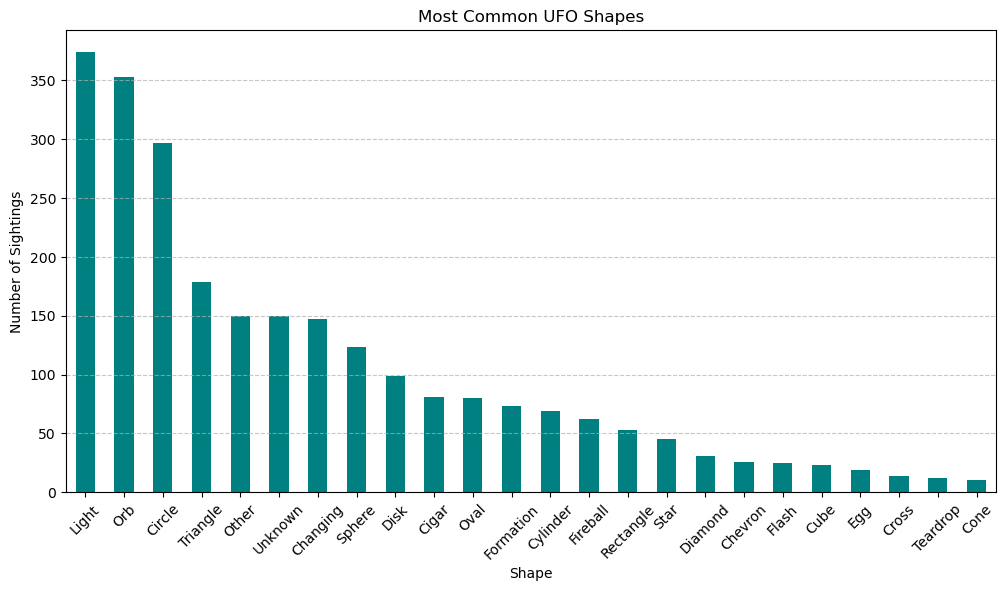

In [ ]:
plt.figure(figsize=(12, 6))
shape_counts.plot(kind="bar", color="teal")
plt.title("Most Common UFO Shapes")
plt.xlabel("Shape")
plt.ylabel("Number of Sightings")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Most Visited Country 

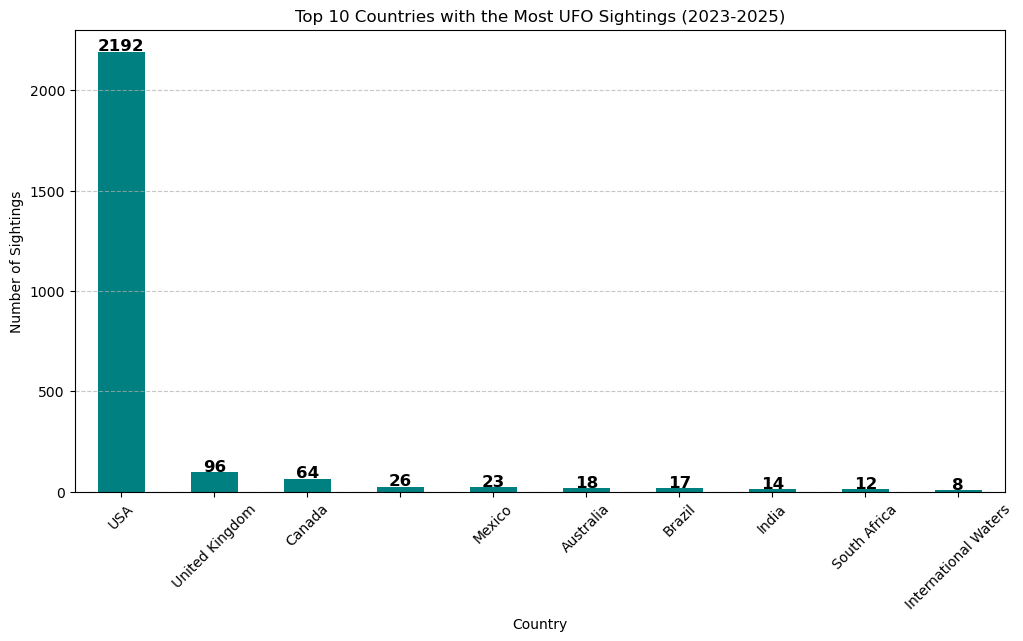

In [ ]:
country_counts = df["Country"].value_counts()
country_counts_max = country_counts.head(10)

plt.figure(figsize=(12, 6))
ax = country_counts_max.plot(kind="bar", color="teal")

plt.title("Top 10 Countries with the Most UFO Sightings (2023-2025)")
plt.xlabel("Country")
plt.ylabel("Number of Sightings")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

#add count labels 
for i, count in enumerate(country_counts_max):
    ax.text(i, count + 5, str(count), ha='center', fontsize=12, fontweight='bold')

#plot
plt.show()


Filter By only USA Visits

In [ ]:
df_usa_only = df[df["Country"] == "USA"].reset_index(drop=True)
df_usa_only.head()

,Link,Month-Year,Occurred,City,State,Country,Shape,Summary,Reported,Media,Explanation
0,Open,2025/02,02/18/2025 22:00,Des Moines,IA,USA,Other,"Military activity. Helicopters first, Snoop36 ...",Y,Aircraft,
1,Open,2025/02,02/18/2025 19:20,Milford,NH,USA,Star,Saw a slow drifting line of white distant star...,Y,Starlink,
2,Open,2025/02,02/18/2025 19:16,Olympia,WA,USA,Cross,Flashing object moving strange,,Drone,
3,Open,2025/02,02/18/2025 17:40,Myrtle Beach,SC,USA,Light,"Large, bright white light above the ocean to t...",,,
4,Open,2025/02,02/18/2025 15:00,Abingdon,VA,USA,Changing,I saw a white orb flickering and staying in on...,,,


In [ ]:
most_common_state =  df_usa_only["State"].value_counts().idxmax()
state_frequency= df_usa_only["State"].value_counts()

state_frequency


State
CA         256
FL         159
TX         119
WA         113
NY         107
AZ          95
CO          80
OH          76
NC          73
PA          67
GA          62
IL          55
MA          54
MI          53
OR          47
WI          47
VA          38
NJ          37
NV          36
MN          34
UT          33
TN          32
IN          31
NM          30
MD          29
MO          29
OK          29
CT          27
KS          25
ID          24
NH          24
LA          24
AL          24
SC          24
ME          21
IA          20
MT          20
AR          19
KY          19
WV          15
NE          14
SD          13
MS          11
VT           8
WY           8
RI           7
DE           6
AK           5
HI           5
ND           2
-            2
DC           2
VI           1
Montana      1
Name: count, dtype: int64


Most common states visited in the USA

In [ ]:

# plotly choreograph 
fig = go.Figure(
    data=go.Choropleth(
        locations=state_frequency.index,  #stae abbreviations
        z=state_frequency.values,  # Num sightings 
        locationmode="USA-states",
        colorscale="Reds",
        colorbar_title="Sightings",
    )
)

#update layout 
fig.update_layout(
    title_text="UFO Sightings Across the USA (2023-2025)",
    geo_scope="usa",  #usa
)

#plot
fig.show()


Histogram of frequency of sightings by month in the USA

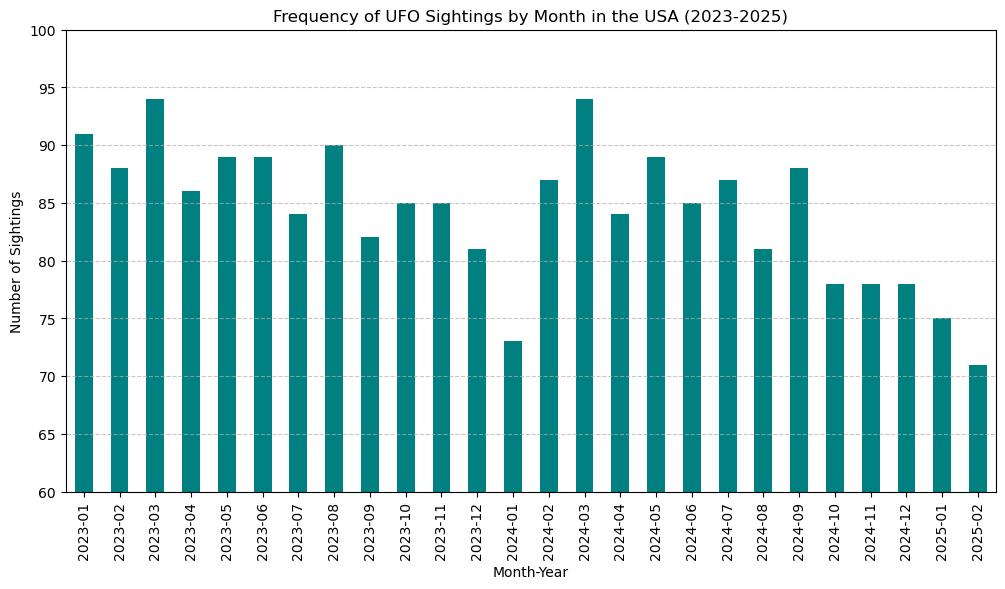

In [ ]:
df_usa_only["Occurred"] = pd.to_datetime(df_usa_only["Occurred"], errors="coerce")

#get year and month 
df_usa_only["Year-Month"] = df_usa_only["Occurred"].dt.to_period("M")

#count sightings per month 
sightings_per_month = df_usa_only["Year-Month"].value_counts().sort_index()


#histoigram of sightings by month 
plt.figure(figsize=(12, 6))
sightings_per_month.plot(kind="bar", color="teal")

plt.title("Frequency of UFO Sightings by Month in the USA (2023-2025)")
plt.xlabel("Month-Year")
plt.ylabel("Number of Sightings")
plt.ylim(60, 100)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)

#plot 
plt.show()

Month with the most frequent reports was March

Why?

Textual Analysis

In [ ]:
reports = [report for report in ufo_data['Summary']]

In [ ]:
def preprocess_text(text):
    if pd.isna(text):  #handle NaN values
        return ""
    doc = nlp(text.lower())
    text = re.sub(r'[^a-z\s]', '', text)
    words = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words]  #lemma and stop word removal
    return ' '.join(words)

processed_reports = [preprocess_text(report) for report in reports]

In [ ]:
print(processed_reports)

['strange shape shift orb hover fly away', 'witness odd light near tv antenna pursue light evade stop turn back come', 'move fast straight', 'small white blue orb move sporadically sky', 'city strange hover shapeshifting object hover place', 'decide report become every night', 'star orb bright light move sideways shoot sky large speed', 'two light move slowly fade several mile west', 'bright object stationary reddish hue shifting color pattern second object pass fade', 'reddish light first think planet due color recollection jupiter sky', 'triangular craft spot ohio', 'several ufo come fly randomly anywhere visible disappear', 'large orange orb sky glow stationary', 'last couple week night warm light shine field across road house light move unconventionally', 'come home gym something tear drop right sky couple second rapidly go straight', 'circle white light move diagonally downward sky second completely disappear', 'white light turn red disappear', 'observe fast move light stop abrupt

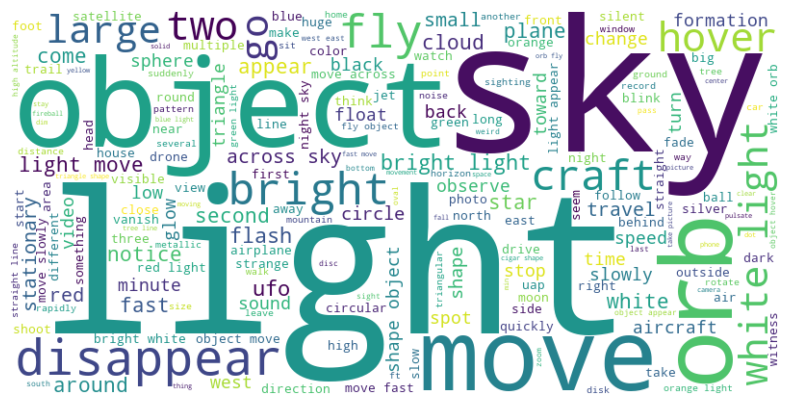

In [ ]:
text_corpus = ' '.join(processed_reports)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

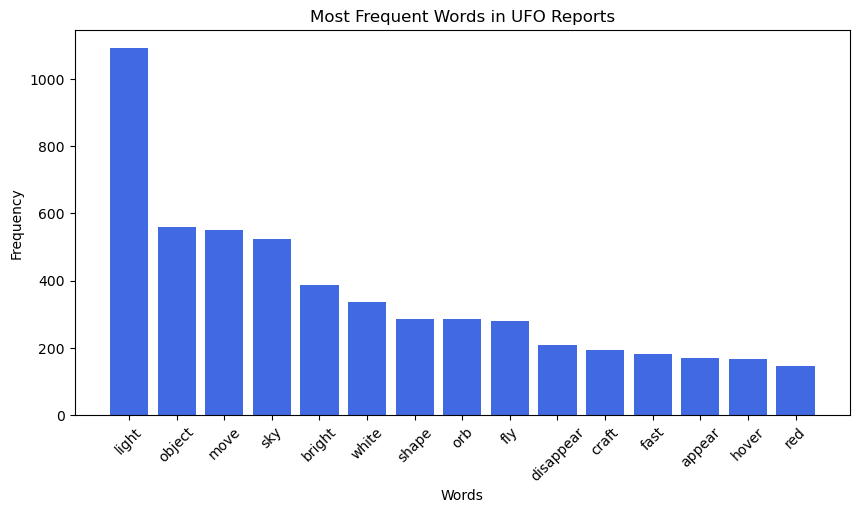

In [ ]:

word_counts = Counter(" ".join(processed_reports).split())

#15 most common words
most_common_words = word_counts.most_common(15)
words, counts = zip(*most_common_words)  # unzip 

#plot
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='royalblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in UFO Reports")
plt.xticks(rotation=45)
plt.show()

Use BERT Tokenization and Sentiment Analysis for more accurate SA analysis

In [ ]:

#pre-trained BERT model 
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
#make all reports string values 
cleaned_reports = [str(report) if isinstance(report, str) else "" for report in reports]

#Run sentiment 
for report in cleaned_reports:
    if len(report.strip()) == 0:  #skip empty reports 
        print("Skipping empty report")
        continue

    try:
        result = sentiment_analyzer(report)
        print(f"Report: {report}\nSentiment: {result[0]['label']}, Score: {result[0]['score']}\n")
    except Exception as e:
        print(f"Error processing report: {report} | Error: {str(e)}")


Report: Strange shape shifting orb that hovered and flew away
Sentiment: 2 stars, Score: 0.4351796507835388

Report: Witnessed odd light near TV antenna, pursued, light evaded us until we stopped, then it turned back and came at us
Sentiment: 1 star, Score: 0.4234645366668701

Report: Moving fast & not straight.
Sentiment: 3 stars, Score: 0.3931411802768707

Report: Small white / Blue orb moving sporadically through the sky
Sentiment: 3 stars, Score: 0.36807507276535034

Report: Above my city a strange hovering shapeshifting object was hovering in one place
Sentiment: 1 star, Score: 0.40872153639793396

Report: I have been seeing them before but now I decided to report on here because it's becoming every night
Sentiment: 4 stars, Score: 0.339215487241745

Report: Looked like a star/orb with very bright light. Moved sideways then shot up in the sky at large speed.
Sentiment: 1 star, Score: 0.49725958704948425

Report: We saw two lights moving slowly, fading in and out, several miles to 

Add Sentiment Analysis Data to our dataframe

In [ ]:
# store sentiment star value and score value 
sentiment_stars = []  #stars 1-5
sentiment_confidence_scores = []  #confidence scores 

#get sentiment scores from earlier 
for report in cleaned_reports:
    if len(report.strip()) == 0:
        sentiment_stars.append(0)  
        sentiment_confidence_scores.append(0)  
        continue

    #extract results 
    stars = int(result[0]['label'].split()[0])  
    confidence_score = result[0]['score']  

    sentiment_stars.append(stars)
    sentiment_confidence_scores.append(confidence_score)

# add to dataframe
ufo_data["Sentiment_Stars"] = sentiment_stars
ufo_data["Sentiment_Confidence"] = sentiment_confidence_scores


,Link,Month-Year,Occurred,City,State,Country,Shape,Summary,Media,Explanation,Validity_Score,Sentiment_Stars,Sentiment_Confidence
0,Open,2025/01,1/30/2025 20:10,Holyoke,MA,USA,Orb,Strange shape shifting orb that hovered and fl...,N,NA,19.036335,1,0.418755
1,Open,2025/01,1/30/2025 19:42,Duluth,MN,USA,Light,"Witnessed odd light near TV antenna, pursued, ...",Y,Planet/Star,31.753555,1,0.418755
2,Open,2025/01,1/30/2025 18:35,Smrjene,Ljubljana,Slovenia,Circle,Moving fast & not straight.,Y,Aircraft,56.477093,1,0.418755
3,Open,2025/01,1/30/2025 18:00,Maldon,England,United Kingdom,Orb,Small white / Blue orb moving sporadically thr...,Y,Drone?,58.925750,1,0.418755
4,Open,2025/01,1/30/2025 7:48,Sfântu Gheorghe,Covasna County,Romania,Changing,Above my city a strange hovering shapeshifting...,Y,NA,28.988942,1,0.418755


Create a Report Confidence/Validity Score Based on BERT SA

In [ ]:

#define creidbility boosting or hurting words 
credible_words = {"pilot", "military", "radar", "confirmed", "investigation", "officer", "witness"}
non_credible_words = {"joke", "dream", "hoax", "fake", "prank"}

#keyword scoring 
def calculate_keyword_score(report):
    words = set(report.lower().split())
    score = sum(10 for word in words if word in credible_words)
    score -= sum(10 for word in words if word in non_credible_words)
    return score

# Store sentiment results while running analysis
sentiment_scores = []  #normalized senitment scores (40+ or -40)
confidence_scores = []  # confidence scores for BErt pieline 

for report in cleaned_reports:
    if len(report.strip()) == 0:
        sentiment_scores.append(0)  
        confidence_scores.append(0)  
        continue

    #sentiment analysis reult 
    result = sentiment_analyzer(report)
    sentiment_stars = int(result[0]['label'].split()[0])  # Extract stars (1-5)
    sentiment_confidence = result[0]['score']  # Extract confidence score (0-1)

    #normalize sentiment stars 
    normalized_sentiment = (sentiment_stars - 3) * 20  

    #scale confidence score 
    confidence_weight = sentiment_confidence * 30  

    sentiment_scores.append(normalized_sentiment)
    confidence_scores.append(confidence_weight)

# Compute raw validity scores using stored sentiment and confidence scores
validity_scores = []
for report, media, sentiment_score, confidence_score in zip(cleaned_reports, ufo_data["Media"], sentiment_scores, confidence_scores):
    
    # Media presence score (30 if media is present, 0 otherwise)
    media_score = 30 if str(media).strip().upper() == "Y" else 0
    
    # Report length score (scaled between 0-30)
    length_score = min(len(report) / 10, 30)  
    
    # Keyword credibility score
    keyword_score = calculate_keyword_score(report)
    
    # Compute final validity score
    total_score = media_score + sentiment_score + confidence_score + length_score + keyword_score
    validity_scores.append(total_score)

# Normalize validity scores between 0-100
scaler = MinMaxScaler(feature_range=(0, 100))
validity_scores = scaler.fit_transform([[score] for score in validity_scores]).flatten()

# Add the scores back to the DataFrame
ufo_data["Sentiment_Stars"] = sentiment_scores  # Store sentiment stars
ufo_data["Sentiment_Confidence"] = confidence_scores  # Store sentiment confidence
ufo_data["Validity_Score"] = validity_scores  # Final validity score



                                              Summary Media  Validity_Score
0   Strange shape shifting orb that hovered and fl...     N       19.036335
1   Witnessed odd light near TV antenna, pursued, ...     Y       31.753555
2                         Moving fast & not straight.     Y       56.477093
3   Small white / Blue orb moving sporadically thr...     Y       58.925750
4   Above my city a strange hovering shapeshifting...     Y       28.988942
..                                                ...   ...             ...
95  Orb moving in the sky, stopped mid sky, then d...     N        3.475513
96  Two points of light appearing and traveling to...     N       25.118483
97                   Abduction that starts as a dream     N       56.872038
98  I was in the hot tub and I looked up because I...     N       41.074250
99  I was smoking outside my house and I saw this ...     N       68.088468

[100 rows x 3 columns]


In [ ]:
ufo_data.head()

,Link,Month-Year,Occurred,City,State,Country,Shape,Summary,Media,Explanation,Validity_Score
0,Open,2025/01,1/30/2025 20:10,Holyoke,MA,USA,Orb,Strange shape shifting orb that hovered and fl...,N,NA,19.036335
1,Open,2025/01,1/30/2025 19:42,Duluth,MN,USA,Light,"Witnessed odd light near TV antenna, pursued, ...",Y,Planet/Star,31.753555
2,Open,2025/01,1/30/2025 18:35,Smrjene,Ljubljana,Slovenia,Circle,Moving fast & not straight.,Y,Aircraft,56.477093
3,Open,2025/01,1/30/2025 18:00,Maldon,England,United Kingdom,Orb,Small white / Blue orb moving sporadically thr...,Y,Drone?,58.925750
4,Open,2025/01,1/30/2025 7:48,Sfântu Gheorghe,Covasna County,Romania,Changing,Above my city a strange hovering shapeshifting...,Y,NA,28.988942


Dataset saved as ufo_reports_with_validity_scores.csv
